In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Table of contents
1. [I. fill missing values](#1)
2. [II. converting continous values into categorical values](#2)
    * 2.1  [age](#2.1)
    * 2.2  [fare](#2.2)
3. [III. converting string values to numeric](#3)
4. [V. drop unnecessary features](#5)
5. [VI. output](#6)

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

## I. fill missing values <a name="1"></a>

In [3]:
#check for the total of null values
total = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [4]:
#check for the total of null values
total = test.isnull().sum().sort_values(ascending = False)
percent = round(test.isnull().sum().sort_values(ascending = False)/len(test)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [5]:
# PLACE OF EMBARKEMENT

# solution 1
# replace missing values with the most common place of embarkment (Southampton
#train['Embarked'].fillna('S',inplace=True)

# solution 2
# identify the context and find passengers who paid similar money for a ticket (Cherbourg)
train[train.Embarked.isnull()]
train.groupby('Embarked', as_index = False)['Fare'].mean()
train.Embarked.fillna("C", inplace = True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


,Embarked,Fare
0,C,59.954144
1,Q,13.276030
2,S,27.079812


In [6]:
#AGE
# create a new feature 'Initial' with salutations
train['Initial'] = 0
for i in train:
    train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.')
    
#restrict the salutations and correct their spellingtr
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
pd.crosstab(train.Initial,train.Sex).T.style.background_gradient(cmap = 'Pastel1_r')

test['Initial'] = 0
for i in test:
    test['Initial'] = test.Name.str.extract('([A-Za-z]+)\.')
test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

# replace unknown age values 
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age']=33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age']=46

test.loc[(test.Age.isnull())&(test.Initial=='Mr'),'Age']=33
test.loc[(test.Age.isnull())&(test.Initial=='Mrs'),'Age']=36
test.loc[(test.Age.isnull())&(test.Initial=='Master'),'Age']=5
test.loc[(test.Age.isnull())&(test.Initial=='Miss'),'Age']=22
test.loc[(test.Age.isnull())&(test.Initial=='Other'),'Age']=46

Initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,186,1,127,0
male,40,0,528,0,9


In [7]:
#CABIN
train['Cabin'].fillna(0,inplace = True)
test['Cabin'].fillna(0,inplace = True)

In [8]:
#FARE
#fill a mean fare in the class
train.groupby('Pclass', as_index = False)['Fare'].mean()
test[test.Fare.isnull()]

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,0,S,Mr


In [9]:
test['Fare'].fillna(13.675550,inplace = True)

In [10]:
# check if all NaN removed
train.isnull().sum()
test.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Initial        0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Initial        0
dtype: int64

##  II. converting continous values into categorical values <a name="2"></a>

questionable as conversion here means losing information as described [here](https://stats.stackexchange.com/questions/60149/should-i-categorise-my-continuous-variable-for-use-in-binary-logistic-regression)

### II.1 age <a name="2.1"></a>

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,Mr,2


1    382
2    325
0    104
3     69
4     11
Name: Age_band, dtype: int64

Text(0.5, 1.08, 'relation between age, class and survival rate')

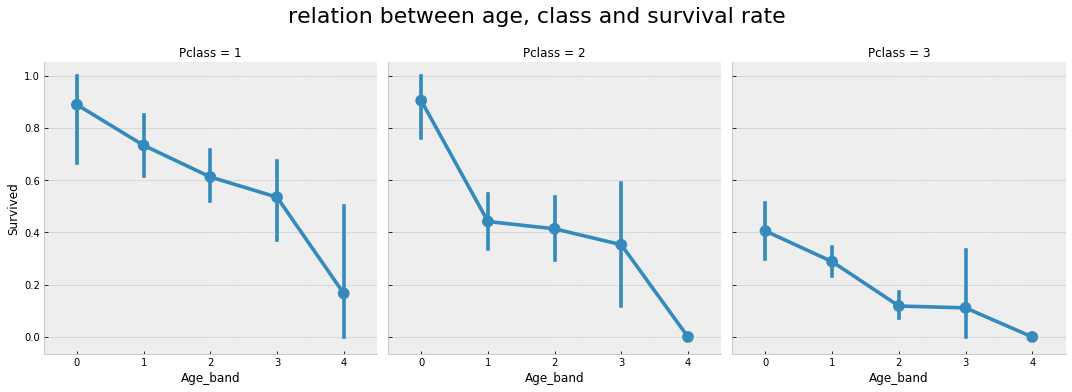

In [11]:
#BINNING
# divide the range from 0-80 into 5 bins; 80/5=16, bins of size 16
train['Age_band'] = 0;
train.loc[train['Age']<=16,'Age_band'] = 0;
train.loc[(train['Age']>16)&(train['Age']<=32),'Age_band'] = 1;
train.loc[(train['Age']>32)&(train['Age']<=48),'Age_band'] = 2;
train.loc[(train['Age']>48)&(train['Age']<=64),'Age_band'] = 3;
train.loc[train['Age']>64,'Age_band'] = 4;
train.head()

test['Age_band'] = 0;
test.loc[test['Age']<=16,'Age_band'] = 0;
test.loc[(test['Age']>16)&(test['Age']<=32),'Age_band'] = 1;
test.loc[(test['Age']>32)&(test['Age']<=48),'Age_band'] = 2;
test.loc[(test['Age']>48)&(test['Age']<=64),'Age_band'] = 3;
test.loc[test['Age']>64,'Age_band'] = 4;

#check the number of passenegers in each band
train['Age_band'].value_counts()

# relation between age, class and survival rate
plot = sns.factorplot('Age_band','Survived',data=train,col='Pclass');
plot.fig.suptitle('relation between age, class and survival rate', y=1.08, size = 22);
plt.show()
#the survival rate decreases as the age increases irrespective of the Pclass

### II.2 fare <a name="2.2"></a>

Text(0.5, 1.08, 'relation between fare category and survival rate')

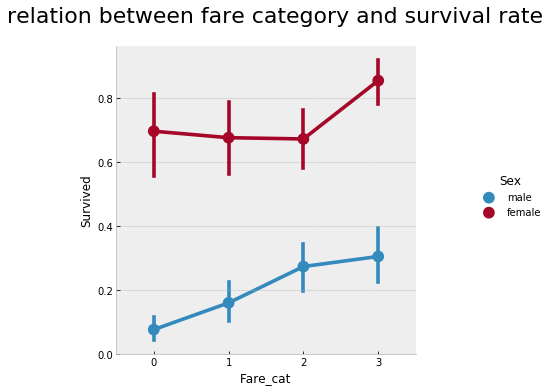

In [12]:
train['Fare_Range'] = pd.qcut(train['Fare'],4);
train.groupby(['Fare_Range'])['Survived'];

# divide the range from 0-512.329 into 4 bins
train['Fare_cat'] = 0;
train.loc[train['Fare']<=7.91,'Fare_cat'] = 0;
train.loc[(train['Fare']>7.91)&(train['Fare']<=14.454),'Fare_cat'] = 1;
train.loc[(train['Fare']>14.454)&(train['Fare']<=31),'Fare_cat'] = 2;
train.loc[(train['Fare']>31)&(train['Fare']<=513),'Fare_cat'] = 3;

test['Fare_Range'] = pd.qcut(test['Fare'],4);
test['Fare_cat'] = 0;
test.loc[test['Fare']<=7.91,'Fare_cat'] = 0;
test.loc[(test['Fare']>7.91)&(test['Fare']<=14.454),'Fare_cat'] = 1;
test.loc[(test['Fare']>14.454)&(test['Fare']<=31),'Fare_cat'] = 2;
test.loc[(test['Fare']>31)&(test['Fare']<=513),'Fare_cat'] = 3;

# relation between fare category and survival rate
plot = sns.factorplot('Fare_cat','Survived',data = train,hue='Sex');
plot.fig.suptitle('relation between fare category and survival rate', y=1.08, size = 22);
plt.show()
# as the Fare_cat increases, the survival chances increase

## III. converting string values to numeric <a name="3"></a>

In [13]:
# sex, embarked, initial
train['Sex'].replace(['male','female'],[0,1],inplace = True);
train['Embarked'].replace(['S','C','Q'],[0,1,2],inplace = True);
train['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace = True);

test['Sex'].replace(['male','female'],[0,1],inplace = True);
test['Embarked'].replace(['S','C','Q'],[0,1,2],inplace = True);
test['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace = True);

In [14]:
train.dtypes
test.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked          int64
Initial           int64
Age_band          int64
Fare_Range     category
Fare_cat          int64
dtype: object

PassengerId       int64
Pclass            int64
Name             object
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked          int64
Initial          object
Age_band          int64
Fare_Range     category
Fare_cat          int64
dtype: object

## IV. drop unnecessary features <a name="4"></a>

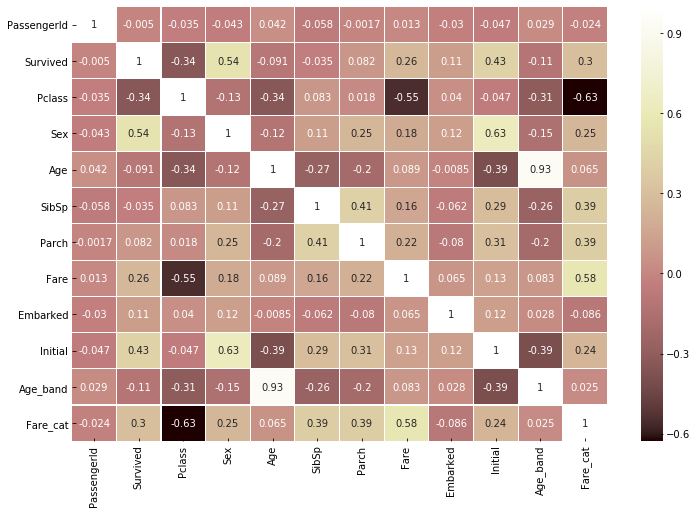

In [15]:
sns.heatmap(train.corr(),annot = True,cmap = 'pink',linewidths = 0.2);
fig = plt.gcf();
fig.set_size_inches(12,8);
plt.show();

## V. output <a name="5"></a>

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Fare_Range,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,0,0,1,"(-0.001, 7.91]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,2,"(31.0, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0,2,1,"(7.91, 14.454]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,2,"(31.0, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0,0,2,"(7.91, 14.454]",1


In [17]:
# plus all features:
test.drop(['PassengerId','Name','Ticket','Cabin','Fare_Range'],axis = 1,inplace = True);
train.drop(['PassengerId','Name','Ticket','Cabin','Fare_Range'],axis = 1,inplace = True);
train.to_csv('train_withFeatures.csv', index = False)
test.to_csv('test_withFeatures.csv', index = False)
train.head()
test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Age_band,Fare_cat
0,0,3,0,22.0,1,0,7.2500,0,0,1,0
1,1,1,1,38.0,1,0,71.2833,1,1,2,3
2,1,3,1,26.0,0,0,7.9250,0,2,1,1
3,1,1,1,35.0,1,0,53.1000,0,1,2,3
4,0,3,0,35.0,0,0,8.0500,0,0,2,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Age_band,Fare_cat
0,3,0,34.5,0,0,7.8292,2,0,2,0
1,3,1,47.0,1,0,7.0000,0,1,2,0
2,2,0,62.0,0,0,9.6875,2,0,3,1
3,3,0,27.0,0,0,8.6625,0,0,1,1
4,3,1,22.0,1,1,12.2875,0,1,1,1


In [18]:
# original cleaned dataset, no additional features
train.drop(['Initial','Age_band','Fare_cat'],axis = 1,inplace = True);
test.drop(['Initial','Age_band','Fare_cat'],axis = 1,inplace = True);
train.to_csv('cleaned_train.csv', index = False)
test.to_csv('cleaned_test.csv', index = False)
train.head()
test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,2
1,3,1,47.0,1,0,7.0000,0
2,2,0,62.0,0,0,9.6875,2
3,3,0,27.0,0,0,8.6625,0
4,3,1,22.0,1,1,12.2875,0
